# AutoFarm - Instance Segmenation with PyTorch

As with most of my writing, I do it mainly to learn. There is an age old truth that by writing down what you learn it solidifies your understanding. So in this post, I will be implementing an instance segmentation model from scratch using the AutoFarm dataset of timelapse images of my basil crop.

This dataset is fairly straightforward. I setup a small planter box with freshly planted basil seeds and took timelapse photography of them over the course of a month as they grew. The images are not annotated, but it should be fairly easy to segment them from the background as we will see later.

The modeling is the tricky part. Instance segmentation is a complex problem when you peel back the layers of complexity that projects like [Detectron2](https://github.com/facebookresearch/detectron2) have implemented for us. It involves several models working together to produce a "instance" and "segmentation".

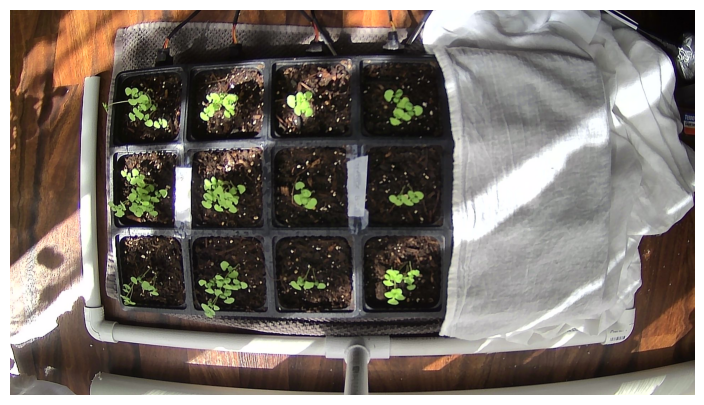

In [2]:
import matplotlib.pyplot as plt
import cv2

root_dir = '/home/jack/Mounts/DiskOne/auto_farm/raw'

capture = cv2.VideoCapture(f'{root_dir}/video_1920x1080.avi')

capture.set(cv2.CAP_PROP_POS_FRAMES, 500)

_, frame = capture.read()
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 5))
plt.imshow(frame)
plt.axis('off')
plt.show()

For instance, take the Mask-RCNN architecture. It was made famous as one of the most de-facto standard models for instance segmentation for it's ability to handle a large variety of objects. But it is actually just a combination of different models working together. It has interchangeable components: a backbone model, a Region Proposal Network (RPN), a mask head, and an object detection head. These models work together to produce the final output. A really good overview of that architecture can be found here: [Understanding Mask R-CNN Basic Architecture](https://shuffleai.blog/blog/Understanding_Mask_R-CNN_Basic_Architecture.html)

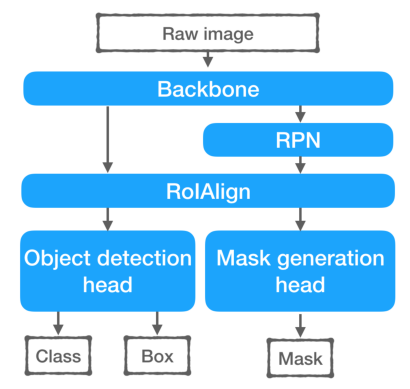

In [11]:
frame = cv2.cvtColor(cv2.imread('./maskrcnn.png'), cv2.COLOR_BGR2RGB)
plt.imshow(frame)
plt.axis('off')
plt.show()

Let's start slowly by first trying to extract the basil plants from the background and build a dataset for our model. We can use a color thresholding technique to segment the plants from the background, and then find the contours to create masks for each instance of the plants.

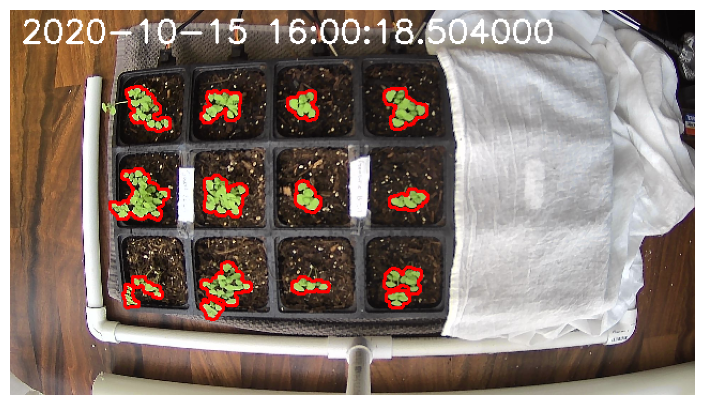

In [7]:
import json
import numpy as np
import pandas as pd

def extract_masks(resolution):
    timestamps = json.load(open(f'{root_dir}/timestamps_{resolution}.json'))
    
    capture = cv2.VideoCapture(f'{root_dir}/video_{resolution}.avi')
    capture.set(cv2.CAP_PROP_FPS, 0)
    
    # skip to frame 1000
    capture.set(cv2.CAP_PROP_POS_FRAMES, 1000)

    lower_green = np.array([[35, 40, 40]])
    upper_green = np.array([[95, 255, 255]])
    
    lower_gray = np.array([[0, 0, 0]])
    upper_gray = np.array([[200, 60, 255]])

    index = 0
    skip_index = 0

    while True:
        ret, frame = capture.read()

        if not ret:
            break

        oframe = frame.copy()
        oframe = cv2.cvtColor(oframe, cv2.COLOR_BGR2RGB)

        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
        
        brightness = np.mean(frame[:, :, 2]) / 255
        
        # we remove frames that are too bright or too dark 
        # as the thresholding doesn't work well in these cases
        if brightness < 0.3 or brightness > 0.7:
            continue
        
        # I found this pipline to work well for my dataset. Nothing impressive.
        # I had to tune the parameters quite a bit. But it works pretty well.
        # The blur and dilation are used to remove noise and fill in the holes.
        mask = cv2.inRange(frame, lower_gray, upper_gray)
        mask = cv2.dilate(mask, (5, 5), iterations=5)
        frame = cv2.bitwise_and(frame, frame, mask=cv2.bitwise_not(mask))
        mask = cv2.inRange(frame, lower_green, upper_green)
        mask = cv2.blur(mask, (9, 9))
        mask = cv2.dilate(mask, (5, 5), iterations=2)

        # removing small contours helps to remove a lot of noise
        contours = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[-2]
        contours = [c for c in contours if cv2.contourArea(c) > 1500]
        
        # remove all pixels not in the contours
        neg_mask = np.zeros_like(mask)
        cv2.drawContours(neg_mask, contours, -1, 255, -1)
        mask = neg_mask
        
        # resize masks to 640x360 to save space but retain aspect ratio
        scale = 640 / mask.shape[1]
        mask = cv2.resize(mask, (640, 360))
        oframe = cv2.resize(oframe, (640, 360))
        for contour in contours:
            contour[:, :, 0] = (contour[:, :, 0] * scale).astype(np.int32)
            contour[:, :, 1] = (contour[:, :, 1] * scale).astype(np.int32)
        
        timestamp = timestamps[index]
        
        if len(contours) > 0:
            yield timestamp, mask, contours, oframe
        
        skip = skip_index * 200
        capture.set(cv2.CAP_PROP_POS_FRAMES, skip)
        
        index = skip
        skip_index += 1

    capture.release()
    
    
for timestamp, mask, contours, frame in extract_masks('1920x1080'):

    for contour in contours:
        cv2.drawContours(frame, [contour], -1, (255, 0, 0), 2)
    
    timestamp = pd.to_datetime(timestamp, unit='ms')
    cv2.putText(frame, str(timestamp), (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

    plt.figure(figsize=(10, 5))
    plt.imshow(frame)
    plt.axis('off')
    plt.show()
    break

Our thresholding technique worked pretty well without the need for any complex instance segmentation model. Plus it runs in real-time on a CPU! But, where is the fun in that? From here, we can save the frames, and then create a dataset formatted for training our model. We won't try to annotate the images by hand, we will just "trust" that our thresholding technique is good enough to segment the plants from the background. Let's do that now.

In [8]:
import os
import json

output_dir = '/home/jack/Mounts/DiskOne/auto_farm/dataset'

os.makedirs(f'{output_dir}', exist_ok=True)

coco_data = {
    'images': [],
    'annotations': [],
    'categories': [
        { 'id': 1, 'name': 'crop' }
    ],
}

for resolution in ['1920x1080', '1280x720']:

    for timestamp, mask, contours, frame in extract_masks(resolution):
        
        frame_path = f'{output_dir}/{timestamp}.png'
        
        cv2.imwrite(frame_path, cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))
        
        image_id = len(coco_data['images'])
        
        coco_data['images'].append({
            'id': image_id,
            'file_name': frame_path,
            'width': mask.shape[1],
            'height': mask.shape[0],
        })
        
        for contour in contours:
            bbox = cv2.boundingRect(contour)
            area = cv2.contourArea(contour)
            segmentation = [contour.flatten().tolist()]
            annotation_id = len(coco_data['annotations'])
            
            coco_data['annotations'].append({
                'id': annotation_id,
                'image_id': image_id,
                'category_id': 1,
                'segmentation': segmentation,
                'area': area,
                'bbox': bbox,
                'iscrowd': 0,
            })

with open(f'{output_dir}/coco.json', 'w') as f:
    json.dump(coco_data, f)

In [9]:
len(coco_data['images']), len(coco_data['annotations'])

(238, 2612)

Awesome! We now have a COCO formatted data that we completely automated. This is a good start for training the model. I won't begin to explain the inaccuracies of this dataset, but as this is just a learning exercise, it should be good enough to get us started. We can now create the `Dataset` class that knows how to load a COCO formatted dataset, and then create a `DataLoader` to feed the data to our model.

In [1]:
import os
import json
import numpy as np
import cv2
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
from torchvision.tv_tensors import Image, BoundingBoxes, Mask

class AutoFarmDataset(Dataset):
    def __init__(self, directory, sett='train'):
        self.directory = directory
        self.coco = json.load(open(os.path.join(directory, 'coco.json')))
        self.annotation_map = {}
        self.image_cache = {}
        
        for a in self.coco['annotations']:
            if a['image_id'] not in self.annotation_map:
                self.annotation_map[a['image_id']] = []
            self.annotation_map[a['image_id']].append(a)
            
        # filter out images with no annotations
        self.coco['images'] = [i for i in self.coco['images'] if i['id'] in self.annotation_map]
        
        all_indices = np.arange(len(self.coco['images']))
        train_indices = np.random.choice(all_indices, int(len(all_indices) * 0.8), replace=False)
        all_indices = np.setdiff1d(all_indices, train_indices)
        test_indices = np.random.choice(all_indices, int(len(all_indices) * 0.5), replace=False)
        val_indices = np.setdiff1d(all_indices, test_indices)
        
        if sett == 'train':
            self.indices = train_indices
        elif sett == 'test':
            self.indices = test_indices
        else:
            self.indices = val_indices


    def __len__(self):
        return len(self.indices)


    def __getitem__(self, index):
        image = self.coco['images'][self.indices[index]]
        image_path = os.path.join(self.directory, os.path.basename(image['file_name']))

        if image_path not in self.image_cache:
            self.image_cache[image_path] = read_image(image_path)
        
        frame = Image(self.image_cache[image_path])
        
        annotations = self.annotation_map[image['id']]
        
        boxes = []
        masks = []
        labels = []

        for annotation in annotations:
            contour = np.array(annotation['segmentation']).reshape(-1, 2)

            # we can recreate the mask by drawing the contour
            mask = np.zeros((image['height'], image['width']))
            mask = cv2.fillPoly(mask, [contour], 1)
            mask = Mask(mask)
            
            # bounding box is in xywh format traditionally for COCO formats.
            # torchvision typically uses xyxy format.
            bbox = annotation['bbox']
            bbox = [bbox[0], bbox[1], bbox[0] + bbox[2], bbox[1] + bbox[3]]
            bbox = BoundingBoxes(bbox, format='xyxy', canvas_size=(image['height'], image['width']))
            
            boxes.append(bbox)
            masks.append(mask)
            labels.append(1)

        return frame, boxes, masks, labels


data_dir = '/home/jack/Documents/Workspace/dataset'
train_loader = DataLoader(AutoFarmDataset(data_dir, sett='train'), batch_size=8, shuffle=True, collate_fn=lambda batch: tuple(zip(*batch)))

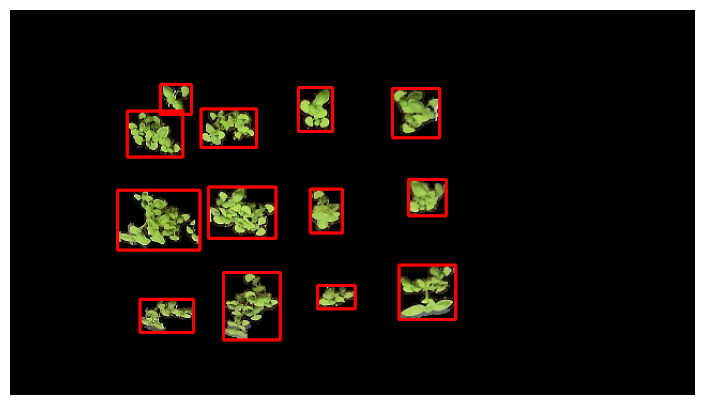

In [8]:
for frames, boxes, masks, labels in train_loader:
    frame = frames[0].permute(1, 2, 0).numpy()
    
    display = frame.copy()
    
    merged_mask = np.zeros_like(masks[0][0].numpy().astype(np.uint8))
    for mask in masks[0]:
        mask = mask.numpy().astype(np.uint8)
        merged_mask = cv2.bitwise_or(merged_mask, mask)
        
    display = cv2.bitwise_and(frame, frame, mask=merged_mask)

    for box in boxes[0]:
        box = box[0]
        box = [int(x) for x in box]
        cv2.rectangle(display, (box[0], box[1]), (box[2], box[3]), (255, 0, 0), 2)

    plt.figure(figsize=(10, 5))
    plt.imshow(display)
    plt.axis('off')
    plt.show()
    break

First we create a custom `Dataset` class that will load the COCO dataset. I created a simple way to slice up the indicies into training, testing, and validation sets as well. We don't have to get too complicated with the COCO format because we are only dealing with a single class (but you could just as easily add the correct label from the COCO `category_id` and it would be fine.) And it works pretty well! No data augmentation at this point, but we can add that later. I love the convience of the `Dataset` and `DataLoader` classes in PyTorch. It makes it incredible easy to work with batching and loading data. Implementing this logic from scratch would be tedious.

Now when we create this model, we don't nessesarily have to recreate the entire ResNet architecture, or implement a Region Proposal Network. This is much too tedious and unnessesary. Although it would be a good learning excercise, we can use pre-trained models from the pytorch library to help us get started. In fact, Pytorch already has a pre-trained model for MaskRCNN that we can use. We just have to set it up to work with our dataset, and train it! It even has pre-trained weights we can load and apply. Experimenting with a completely untrained model and not freezing any layers, each epoch takes around 1.5 minutes to train. If we assume we have to train for 1000 epochs at the minimum, that would take an entire day to train! Applying pre-trained weights and freezing the layers, in other words, transfer learning, we can train the model much faster as we will see.

In [2]:
import torch as t
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights
from torchvision.models import efficientnet_v2_s, EfficientNet_V2_S_Weights
from torchvision.models import efficientnet_b3, EfficientNet_B3_Weights
from torchvision.models import mobilenet_v3_small, MobileNet_V3_Small_Weights
from torchvision.ops import nms as non_max_suppression

def to_cpu(images, targets):
    """
    Have to move things to the CPU when we are done.
    """
    images = images.cpu()
    for target in targets:
        for key in target:
            target[key] = target[key].cpu()


def to_gpu(images, boxes, masks, labels):
    """
    Need to move things to the GPU and convert them to the right data types.
    """
    images = t.stack(images).float().cuda()
    targets = [
        {
            'masks': t.stack(m).type(t.uint8).cuda(),
            'labels': t.tensor(l).cuda(),
            'boxes': t.stack(b).squeeze(1).cuda(),
        } for b, m, l in zip(boxes, masks, labels)
    ]
    return images, targets


def get_backbone(name):
    """
    We need to set the out_channels attribute of the backbone to the number of channels in the final feature map.
    If you print the model, you will see the last layer of the backbone and know how many channels it has.
    """
    if name == 'mobilenet_v2':
        backbone = mobilenet_v2(weights=MobileNet_V2_Weights.IMAGENET1K_V2).features
        backbone.out_channels = 1280
        return backbone

    if name == 'efficientnet_v2_s':
        backbone = efficientnet_v2_s(weights=EfficientNet_V2_S_Weights.IMAGENET1K_V1).features
        backbone.out_channels = 1280
        return backbone

    if name == 'efficientnet_b3':
        backbone = efficientnet_b3(weights=EfficientNet_B3_Weights.IMAGENET1K_V1).features
        backbone.out_channels = 1536
        return backbone
    
    if name == 'mobilenet_v3_small':
        backbone = mobilenet_v3_small(weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1).features
        backbone.out_channels = 576
        return backbone
    
    
def filter_with_confidence(pred, mask_height, mask_width, confidence_threshold=0.5, iou_threshold=0.5):
    """
    Filter out predictions with confidence below the threshold and apply non-maximum suppression.
    """
    nms_indicies = non_max_suppression(pred['boxes'], pred['scores'], iou_threshold)
    pred = {key: pred[key][nms_indicies] for key in pred}
    
    # filter out predictions with confidence below the threshold.
    remaining = pred['scores'] > confidence_threshold
    
    # we default to empty tensors if no predictions are left.
    conf_preds = {
        'boxes': t.empty((0, 4)),
        'masks': t.empty((0, mask_height, mask_width)).type(t.uint8),
        'labels': t.empty(0),
        'scores': t.empty(0),
    }
    if remaining.sum():
        conf_preds = {
            'boxes': pred['boxes'][remaining],
            'masks': (pred['masks'][remaining] > 0.5).type(t.uint8),
            'labels': pred['labels'][remaining],
            'scores': pred['scores'][remaining],
        }
        
    return conf_preds

In [3]:
import time
from tqdm import tqdm
import torch as t
import torch.nn as nn
import torchvision as tv
from torchvision.models.detection.anchor_utils import AnchorGenerator
from torchvision.models.detection import MaskRCNN
from torchmetrics.detection.mean_ap import MeanAveragePrecision


class AutoFarmModel(nn.Module):
    
    def __init__(self, model_path, resume=False):
        super(AutoFarmModel, self).__init__()
        
        self.model_path = model_path
        
        backbone = get_backbone('mobilenet_v3_small')
        
        # freeze the backbone except the final 2 layers
        for param in backbone.parameters():
            param.requires_grad = False
        for param in backbone[-2:].parameters():
            param.requires_grad = True
        
        # anchor sizes and aspect ratios. We can optimize this later
        # by using a k-means clustering algorithm to find the best
        # anchor sizes and aspect ratios for our dataset. Classically,
        # these are the defaults.
        anchor_generator = AnchorGenerator(
                sizes=((32, 64, 128, 256),),
                aspect_ratios=((0.5, 1.0, 2.0),)
        )
        
        # We could use a different roi pooler for the mask or object head. But the default is fine for now.
        #roi_pooler = MultiScaleRoIAlign(featmap_names=['0'], output_size=7, sampling_ratio=2)
        #mask_roi_pooler = MultiScaleRoIAlign(featmap_names=['0'], output_size=14, sampling_ratio=2)

        # We don't really have 2 classes. We only have one. But we need to have 2 classes
        # for the model to work right.
        self.model = MaskRCNN(
            backbone=backbone,
            progress=True,
            max_size=360,
            num_classes=2,
            rpn_anchor_generator=anchor_generator,
        ).float().cuda()
        
        if resume:
            self.model.load_state_dict(t.load(self.model_path))


    def forward(self, x):
        return self.model(x['image'], x['targets'])


    def save(self):
        t.save(self.model.state_dict(), self.model_path)


    def validate(
        self,
        title: str,
        dataset: DataLoader,
        iou_threshold=0.5,
        confidence_threshold=0.6
    ):
        metrics = {
            'box_ap': MeanAveragePrecision(iou_type='bbox'),
            'mask_ap': MeanAveragePrecision(iou_type='segm'),
        }

        self.model.eval()
        
        progress = tqdm(total=len(dataset.dataset), desc=f'{title} -->', position=0, leave=True)
        
        with t.no_grad():

            for frames, boxes, masks, labels in dataset:
                frames, targets = to_gpu(frames, boxes, masks, labels)

                height, width = frames.shape[-2:]

                with t.cuda.amp.autocast():
                    outputs = self.model(frames)
                
                to_cpu(frames, targets)
                outputs = [{k: v.cpu() for k, v in output.items()} for output in outputs]
                
                for index in range(len(targets)):
                    pred = outputs[index]
                    target = targets[index]
                    pred['masks'] = (pred['masks'] > 0.5).type(t.uint8).squeeze()
                    
                    conf_preds = filter_with_confidence(pred, height, width, confidence_threshold, iou_threshold)
                    
                    metrics['mask_ap'].update([conf_preds], [target])
                    metrics['box_ap'].update([conf_preds], [target])

                progress.update(len(frames))
                progress.refresh()

        mask_ap = metrics['mask_ap'].compute()
        box_ap = metrics['box_ap'].compute()
        
        val_metrics = {
            'mask_ap': f"{mask_ap.get('map', 0):.4f}",
            'mask_ap50': f"{mask_ap.get('map_50', 0):.4f}",
            'mask_ap75': f"{mask_ap.get('map_75', 0):.4f}",
            'box_ap': f"{box_ap.get('map', 0):.4f}",
            'box_ap50': f"{box_ap.get('map_50', 0):.4f}",
            'box_ap75': f"{box_ap.get('map_75', 0):.4f}",
        }
        
        progress.set_postfix(**val_metrics)
        progress.close()


    def train(
        self,
        train_dataset: DataLoader,
        val_dataset: DataLoader,
        test_dataset: DataLoader,
        learning_rate=0.001,
        epochs=1000,
        val_epochs=10,
        iou_threshold=0.5,
        confidence_threshold=0.6,
    ):
        # Adam optimizer. Pretty standard these days as an all around good optimizer.
        optimizer = t.optim.Adam(self.model.parameters(), lr=learning_rate)
        
        # Exponential learning rate decay. This is typically what I default to.
        scheduler = t.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)
        
        # Gradient scaler for mixed precision training. Definetely helps with memory usage and training speed.
        scaler = t.cuda.amp.GradScaler()
    
        with t.autograd.set_detect_anomaly(False):
            val_index = 0
            for epoch in range(epochs):
                val_index += 1
                
                self.model.train()
                
                running_loss = 0.0
                progress = tqdm(total=len(train_dataset.dataset), desc=f'Training --> Epoch {epoch+1}/{epochs}', position=0, leave=True)
                epoch_start = time.time()

                for frames, bboxes, masks, labels in train_dataset:
                    images, targets = to_gpu(frames, bboxes, masks, labels)

                    optimizer.zero_grad()
                    with t.cuda.amp.autocast():
                        loss = self.model(images, targets)
                        loss = sum(loss.values())
                    scaler.scale(loss).backward()
                    scaler.step(optimizer)
                    scaler.update()
                    
                    running_loss += loss

                    to_cpu(images, targets)
                    
                    progress.set_postfix(loss=f'{loss:.6f}')
                    progress.update(len(images))
                    progress.refresh()

                epoch_loss = running_loss / (len(train_dataset.dataset) / train_dataset.batch_size)
                epoch_time = time.time() - epoch_start

                progress.set_postfix(loss=f'{epoch_loss:.6f}', time=f'{epoch_time:.2f}s')
                progress.close()
                    
                scheduler.step()
                
                if val_index == val_epochs:
                    val_index = 0
                    self.save()
                    self.validate('Validation', val_dataset, iou_threshold, confidence_threshold)

            self.save()
            self.validate('Test', test_dataset, iou_threshold, confidence_threshold)

The MaskRCNN model is a beast! The standard implementation of the MaskRCNN model utilizes the ResNet50 backbone with FPN (feature pyramid network). But this is a very heavy and robust model that can handle a very large variety of objects. For this dataset, we can probably get away with a much simpler model that will run with less GPU memory, train faster, and especially inference faster. Fortunately, the Pytorch library has already built in a way to modify the architecture by swapping in different backbones, RPN (regional proposal network) configurations, and more: [Pytorch MaskRCNN Implementation](https://github.com/pytorch/vision/blob/main/torchvision/models/detection/mask_rcnn.py#L27).

When implementing this ourselves, we can add quite a bit of detail that really allows use to control the training process. We have implemented:

- A custom `Dataset` class that loads the COCO formatted dataset
- An optimizer featuring `Adam` and learning rate scheduler with `ExponentialLR`
- Automatic Mixed Precision (AMP) with gradient clipping to speed up training
- Custom backbone network trying flavors of `EfficientNet` and `MobileNet`.
- Model freezing and transfer learning with pre-trained weights.
- Custom anchor box sizes and aspect ratios for the RPN
- A validation loop that implements the non-maximum suppression filter and calculates Mean Average Precision (mAP) using `torchmetrics`
- A training loop that saves the model weights periodically on the validation step.
- An informative progress bar that shows the training and validation metrics.

And after all that, we could still implementing early stopping criteria based on the validation metrics, add different types of validation/training metrics, add data augmentation to the dataset, add quantization awareness to the training loop, and even integration with MLFlow so we can setup experiments by hyperparameter tuning and visualizing the metrics graphically.

Trust me, it took me a good number of hours (days really) squeezing and unsqueezing tensors and reviewing documentation until I got the model to work. But it was totally worth it. It helps to understand the fundamentals instead of relying on packages like Detectron2 that limit your understanding and limit what you can actually do. In fact, I recommend implementing it yourself at this level as you can really add a lot of detail and control to the training process. It's a great learning experience.

In [5]:
data_dir = '/home/jack/Documents/Workspace/dataset'
model_path = '/home/jack/Documents/Workspace/auto_farm_model.pth'

model = AutoFarmModel(model_path=model_path, resume=False)

collate_fn = lambda batch: tuple(zip(*batch))
train_loader = DataLoader(AutoFarmDataset(data_dir, sett='train'), batch_size=32, shuffle=True, num_workers=4, prefetch_factor=2, collate_fn=collate_fn)
test_loader = DataLoader(AutoFarmDataset(data_dir, sett='test'), batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(AutoFarmDataset(data_dir, sett='validation'), batch_size=32, shuffle=True, collate_fn=collate_fn)

print('Training on:', len(train_loader.dataset), 'samples')
print('Validating on:', len(val_loader.dataset), 'samples')
print('Testing on:', len(test_loader.dataset), 'samples')

model.train(
    train_loader,
    val_loader,
    test_loader,
    learning_rate=0.0001,
    epochs=100,
    val_epochs=10,
    iou_threshold=0.5,
    confidence_threshold=0.7,
)

Training on: 190 samples
Validating on: 24 samples
Testing on: 24 samples


Test -->: 100%|██████████| 24/24 [00:01<00:00, 16.20it/s, box_ap=0.5607, box_ap50=0.8153, box_ap75=0.6199, mask_ap=0.3868, mask_ap50=0.8031, mask_ap75=0.3111]


Wow! When we originally trained a typical ResNet50 model with FPN, we were getting much slower training times. But now that we have swapped the backbone and added Automatic Mixed Precision (AMP), we are getting much faster training times. And still, after utilizing a much simpler model (MobileNetV3), the metrics are showing a fairly good mAP score.

We can visualize some of the results below.

Inference time: 0.0225 images/s


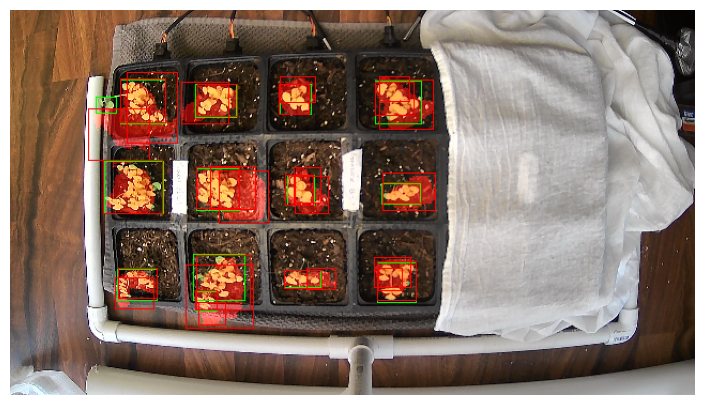

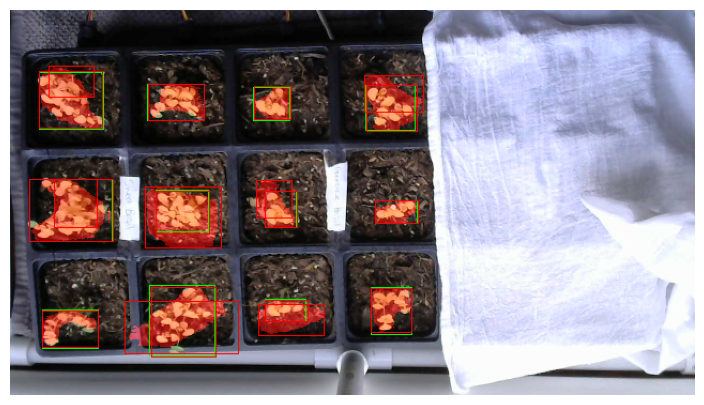

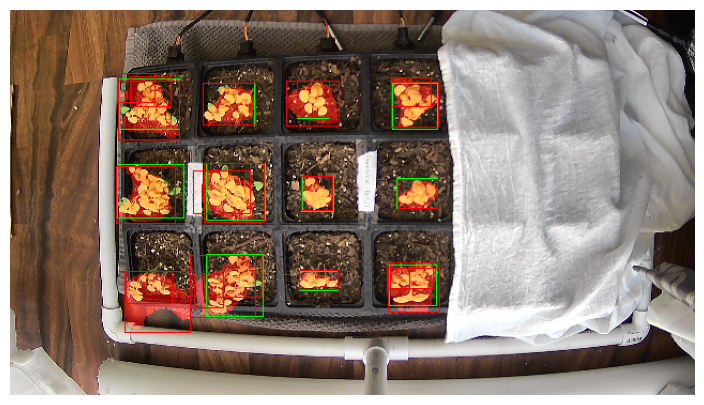

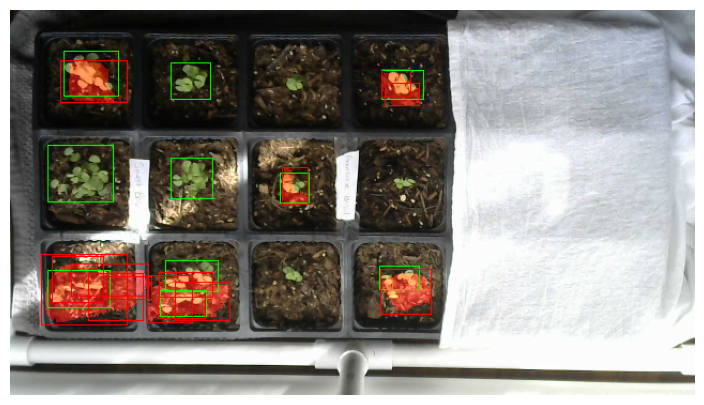

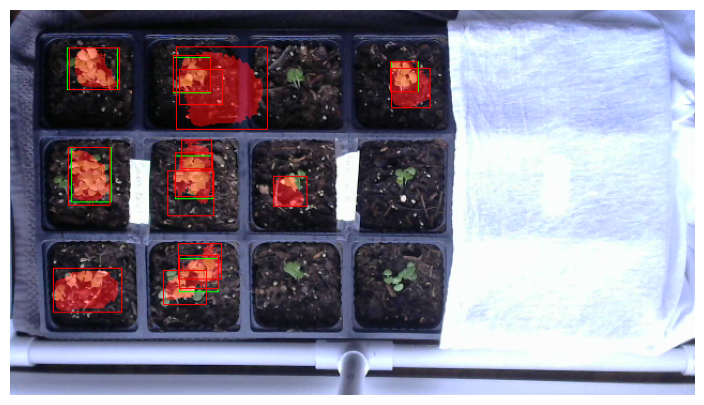

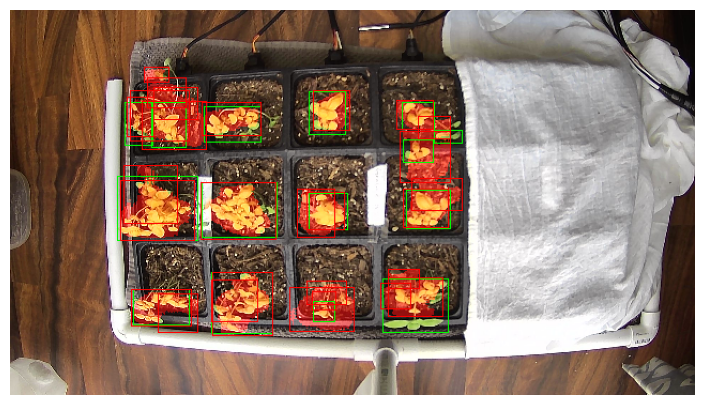

In [27]:
def display_output(frame, pred, target):
    frame = frame.permute(1, 2, 0).cpu().numpy().astype(np.uint8)
    
    display = frame.copy()
    
    pred_boxes = pred['boxes'].cpu().numpy()
    target_boxes = target['boxes'].cpu().numpy()
    pred_masks = pred['masks'].cpu().numpy()
    
    merged_mask = np.zeros_like(pred_masks[0])
    for mask in pred_masks:
        merged_mask = cv2.bitwise_or(merged_mask, mask)

    alpha_mask = np.zeros_like(display)
    alpha_mask[:, :, 0] = merged_mask * 255
    display = cv2.addWeighted(display, 1, alpha_mask, 0.5, 0)

    for box in target_boxes:
        box = [int(x) for x in box]
        cv2.rectangle(display, (box[0], box[1]), (box[2], box[3]), (0, 255, 0), 1)
    
    for box in pred_boxes:
        box = [int(x) for x in box]
        cv2.rectangle(display, (box[0], box[1]), (box[2], box[3]), (255, 0, 0), 1)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(display)
    plt.axis('off')
    plt.show()


model.model.eval()

with t.no_grad():

    for frames, boxes, masks, labels in val_loader:
        frames, targets = to_gpu(frames, boxes, masks, labels)

        height, width = frames.shape[-2:]

        inference_start = time.time()

        with t.cuda.amp.autocast():
            outputs = model.model(frames)

        inference_time = (time.time() - inference_start) / len(frames)
        print(f'Inference time: {inference_time:.4f} images/s')
        
        for index in range(len(targets)):
            pred = outputs[index]
            target = targets[index]
            pred['masks'] = pred['masks'].squeeze()
            pred['masks'] = (pred['masks'] > 0.5).type(t.uint8)
            target['boxes'] = target['boxes'].squeeze()
            
            display_output(frames[index], pred, target)
            
            if index >= 5:
                break

        to_cpu(frames, targets)
        
        break

Certainly not a terrible model! Although some of the output is questionable. We have to remember that this was a completely "unsupervised" dataset and no annotations were actually made by hand. Further, no data augmentation either to inflate or modify the existing dataset was performed. But WOW! Incredible results for such a simple model. Note the inference time is also incredible fast as well (And my RTX 3060 is no speed demon by any means).

# Conclusion

What a project! Back in 2020 when the world collapsed and we couldn't go outside, I wanted to setup an experiment, collecting my own dataset, and explore machine learning on it. It's taken some time, but I've finally gone back and looked at the dataset again. Instance segmentation is definetely a complex problem. And it's not done being innovated on either. The newest architecture taking the world by storm is the YOLO (You Only Look Once) architecture. But, the MaskRCNN architecture is still just as robust and carries about just as much accuracy.

We don't have to beat our GPU's to death with the most complex models for some of the most simple tasks. Exploring the fundamentals, we are able to simplify our model and get some pretty good results (and probably fast enough to run on a Raspberry Pi CPU).

I hope you enjoyed this post. I certainly enjoyed writing it and implementing everything.